Lets read in the data:


In [1]:
import pandas as pd
import numpy as np
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)  # Using json.loads instead of eval()

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')



In [3]:
df = getDF('../data/Cell_Phones_and_Accessories_5.json.gz')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1128437 entries, 0 to 1128436
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1128437 non-null  float64
 1   verified        1128437 non-null  bool   
 2   reviewTime      1128437 non-null  object 
 3   reviewerID      1128437 non-null  object 
 4   asin            1128437 non-null  object 
 5   style           605241 non-null   object 
 6   reviewerName    1128302 non-null  object 
 7   reviewText      1127672 non-null  object 
 8   summary         1127920 non-null  object 
 9   unixReviewTime  1128437 non-null  int64  
 10  vote            92034 non-null    object 
 11  image           27107 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 104.4+ MB


## Data Dictionary

| Column name    | Datatype | Measures| Notes|
| -------------- | -------- | ---------------------------------------------------- | --------------------------------------- |
| overall        | float    | Overall star rating of review   |                                         |
| verified       | boolean  | Whether the review has been verified as real or not. | |
| reviewTime     | object   | Time of review    | If needed can change type to datetime64 |
| reviewerID     | object   | Unique ID of reviewer                                |                                         |
| asin           | object   | Product metadata  |Amazon Standard Identification Number|
| style          | object   | Product metadata                                     |                                         |
| reviewerName   | object   | Name of reviewer                                     |                                         |
| reviewText     | object   | Textual contents of review                           |                                         |
| summary        | object   | Textual summary of review                            |                                         |
| unixReviewTime | int64    | Time of review since Unix Epoch on January 1st, 1970 |                                         |
| vote           | object   | Count of usefulness vote                             |                                         |
| image          | object   | Image of product reviewed                            |                                         |

In [5]:
df.isna().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
style              523196
reviewerName          135
reviewText            765
summary               517
unixReviewTime          0
vote              1036403
image             1101330
dtype: int64

In [6]:
(df.isna().sum())/(df.shape[0])

overall           0.000000
verified          0.000000
reviewTime        0.000000
reviewerID        0.000000
asin              0.000000
style             0.463647
reviewerName      0.000120
reviewText        0.000678
summary           0.000458
unixReviewTime    0.000000
vote              0.918441
image             0.975978
dtype: float64

In [7]:
df[['overall']].value_counts(normalize=True)

overall
5.0        0.626564
4.0        0.163439
3.0        0.087071
1.0        0.072258
2.0        0.050667
Name: proportion, dtype: float64

In [8]:
df['verified'].value_counts(normalize=True)

verified
True     0.874948
False    0.125052
Name: proportion, dtype: float64

we only want verified reviews:

"After someone submits a review, we check if they:

Bought or used the item on Amazon;
Paid a price available to most Amazon shoppers.
If we confirm both, we label the review as Verified Purchase."
Lets make a simplified version of our data containing only rating and text review and also the product identifier (asin), including only the verified reviews containing textual data.

In [9]:
def extract(dataframe):
    '''
    assumes data from amazon reviews, outputs new dataframe with only verified reviews containing overall rating, review and summary

    '''
    out = dataframe.copy()
    out = out[["overall", "verified", "reviewText", "asin"]]
    out = out[out["verified"]==True]
    out = out.drop("verified", axis=1)
    out.info()
    out = out.dropna()
    out = out.drop_duplicates(ignore_index=True)
    return out
    

In [10]:
new_df = extract(df)

<class 'pandas.core.frame.DataFrame'>
Index: 987324 entries, 0 to 1128436
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     987324 non-null  float64
 1   reviewText  986589 non-null  object 
 2   asin        987324 non-null  object 
dtypes: float64(1), object(2)
memory usage: 30.1+ MB


In [11]:
new_df.dropna(inplace=True)

In [12]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975581 entries, 0 to 975580
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     975581 non-null  float64
 1   reviewText  975581 non-null  object 
 2   asin        975581 non-null  object 
dtypes: float64(1), object(2)
memory usage: 22.3+ MB


In [13]:
def rating_distribution(data):

    values, counts = np.unique(data['overall'], return_counts=True)
    normalized_counts = counts/counts.sum()

    plt.figure()
    plt.bar(values, normalized_counts * 100)
    plt.xlabel("Review rating")
    plt.ylabel('% of reviews')
    plt.title("Rating distribution")
    plt.show()
    return normalized_counts
    

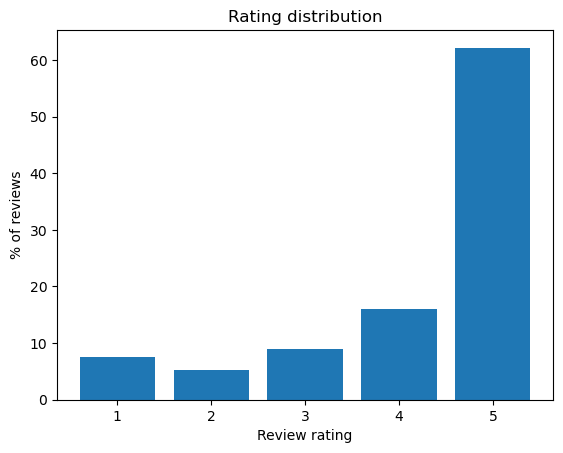

array([0.07526079, 0.05257072, 0.08971679, 0.16078931, 0.62166237])

In [14]:
rating_distribution(new_df)

It will be useful to know the length of a review

In [15]:
rev_len = list()
for review in new_df["reviewText"]:
    rev_len.append(len(review))

In [16]:
new_df["length"] = rev_len

In [17]:
new_df["length"].describe()

count    975581.000000
mean        210.164239
std         363.319923
min           1.000000
25%          35.000000
50%         110.000000
75%         241.000000
max       33457.000000
Name: length, dtype: float64

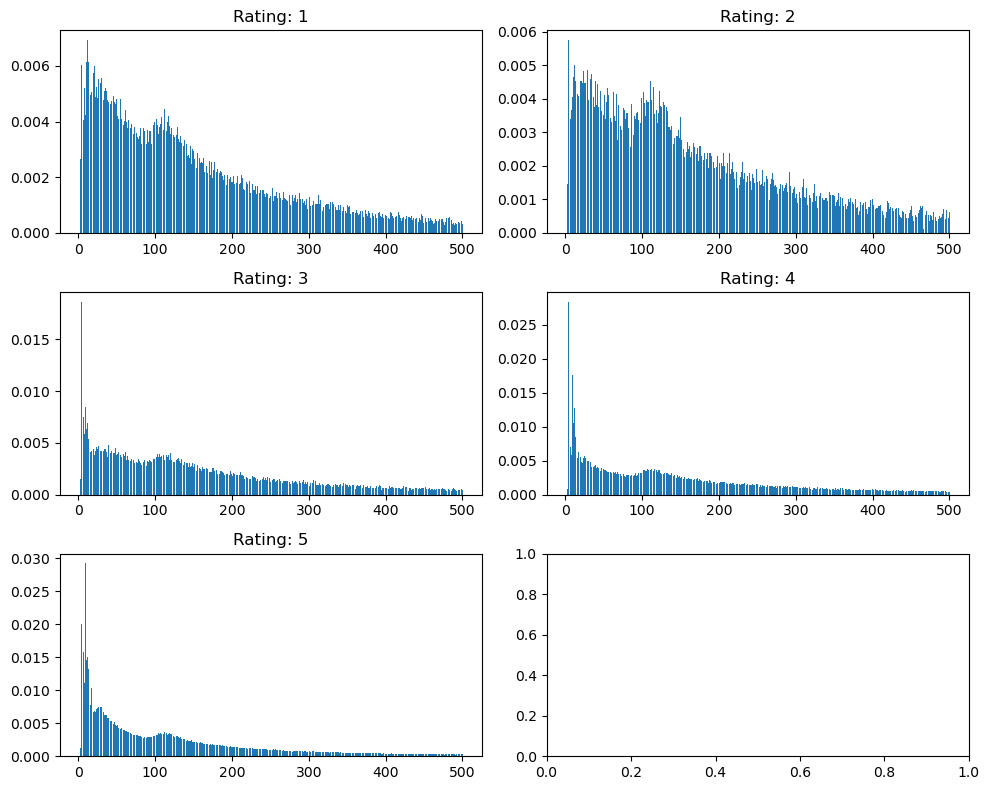

In [18]:
new = new_df[new_df["length"]<=500].copy()

plt.subplots(3,2, figsize=(10,8))
for i in range(1,6):
    len_dist = new["length"][new["overall"]==i].value_counts().reset_index()
    len_dist['count_norm']=len_dist['count']/len_dist["count"].sum()
    plt.subplot(3,2,i)
    # plt.bar(len_dist["length"],len_dist['count'])
    plt.bar(len_dist["length"],len_dist['count_norm'])
    plt.title(f"Rating: {i}")
plt.tight_layout()
plt.show()

In [19]:
asin_dict = dict(new['asin'].value_counts())

In [21]:
x_d = list(asin_dict.keys())
y_d = list(asin_dict.values())


In [22]:
plt.scatter(x=x_d, y=y_d)

Error in callback <function flush_figures at 0x2af9504c0> (for post_execute):


KeyboardInterrupt: 